In [27]:
!pip install -qU langchain langsmith langchain-core langchain-community langchain-experimental langchain-openai langchain-groq pypdf langchain-text-splitters langchain-chroma faiss-cpu sentence_transformers google-search-results wikipedia duckduckgo-search arxiv langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 44.3 MB/s eta 0:00:00


# Load Envs

In [2]:
import os
from google.colab import userdata
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['HUGGINGFACEHUB_API_TOKEN'] = userdata.get('HUGGINGFACEHUB_API_TOKEN')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['PINECONE_API_KEY'] = userdata.get('PINECONE_API_KEY')
os.environ['SERPAPI_API_KEY'] = userdata.get('SERPAPI_API_KEY')

# Set up Langsmith

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "langgraph_learning"

## [Types of Agents](https://python.langchain.com/v0.1/docs/modules/agents/agent_types/)

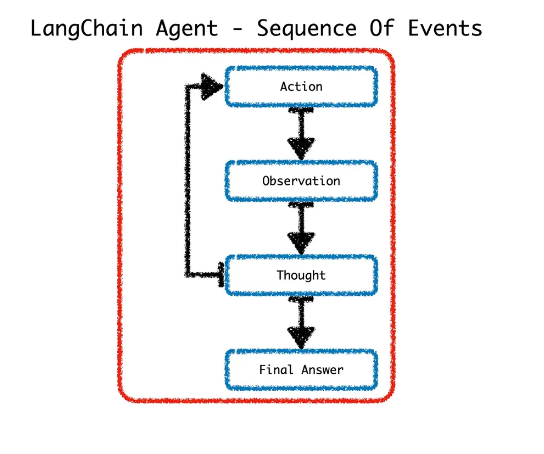

In [4]:
from langchain_groq import ChatGroq

llm = ChatGroq(model = 'llama-3.1-8b-instant')

# Tools

In [6]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

In [7]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [8]:
from langchain_core.tools import BaseTool
from pydantic import BaseModel, Field
from math import pi, sqrt, cos, sin
from typing import Union, Optional, Type
import re

In [9]:
class CircumferenceTool(BaseTool):
  name: str = "Circumference Calculator"
  description: str = " Useful when you need to calculate circumference of a circle using the radius."

  def _run(self, radius: Union[str, int, float]):
    # Extract the number (including decimals)
    number = re.findall(r"[-+]?\d*\.\d+|\d+", radius)

    # Convert to float or int
    if number:
      extracted_radius = float(number[0])
      return extracted_radius*2.0*pi

  def _arun(self, radius: Union[int, float]):
    raise NotImplementedError("This Tool Doesnot support async")

In [10]:
desc = (
    "Useful when you need to calculate the length of an hypotenuse " +
    "given one or two sides of a triangle and/or an angle (in degrees). " +
    "To use this tool, there must be atleast two of the following parameters:" +
    "['adjacent_side', 'opposite_side', 'angle']"
)

In [11]:
class PythagorasTool(BaseTool):
  name: str = "Hypotenuse Calculator"
  description: str = desc

  def _run(
      self,
      adjacent_side: Optional[Union[int, float]] = None,
      opposite_side: Optional[Union[int, float]] = None,
      angle: Optional[Union[int, float]] = None
  ):
    # check for the values we have been given
    if adjacent_side and opposite_side:
        return sqrt(float(adjacent_side)**2 + float(opposite_side)**2)

    elif adjacent_side and angle:
        return adjacent_side / cos(float(angle))

    elif opposite_side and angle:
        return opposite_side / sin(float(angle))

    else:
        return "Could not calculate the hypotenuse of the triangle. Need two or more of `adjacent_side`, `opposite_side`, or `angle`."

  def _arun(self, query:str):
    raise NotImplementedError("This tool doesnot support async")

In [12]:
tools = [search, wikipedia, CircumferenceTool(), PythagorasTool()]

## React Agent

In [13]:
from langchain import hub

# Get the prompt to use - you can modify this!
# prompt = hub.pull("hwchase17/openai-functions-agent")
prompt = hub.pull("hwchase17/react")

In [14]:
prompt

PromptTemplate(input_variables=['agent_scratchpad', 'input', 'tool_names', 'tools'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react', 'lc_hub_commit_hash': 'd15fe3c426f1c4b3f37c9198853e4a86e20c425ca7f4752ec0c9b0e97ca7ea4d'}, template='Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}')

In [15]:
prompt.input_variables

['agent_scratchpad', 'input', 'tool_names', 'tools']

In [17]:
print(prompt.template)

Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}


In [18]:
from langchain.agents import create_react_agent
# ReAct Agent
agent = create_react_agent(llm, tools, prompt) # agent has LLM, instructions and tools it can use.


from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent, tools=tools)

In [24]:
agent_executor.invoke({"input": "What is the circumference of a circle that has a radius of 7.81mm?"})

{'input': 'What is the circumference of a circle that has a radius of 7.81mm?',
 'output': 'Agent stopped due to iteration limit or time limit.'}

In [20]:
agent_executor.invoke({"input": "Who is MK Gandhi?"})

{'input': 'Who is MK Gandhi?',
 'output': "Mohandas Karamchand Gandhi (also known as Mahatma Gandhi) was an Indian lawyer, anti-colonial nationalist, and political ethicist who employed nonviolent resistance to lead the successful campaign for India's independence from British rule."}

# RAG Agent

In [25]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

In [26]:
search.invoke("what is the weather in SF")

/usr/local/lib/python3.10/dist-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


'Thu 02 | Night ... Partly cloudy skies this evening will give way to occasional showers overnight. Low near 50F. Winds E at 5 to 10 mph. Chance of rain 40%. Hourly Weather · 1 PM 58°. rain drop 0% · 2 PM 59°. rain drop 0% · 3 PM 60°. rain drop 0% · 4 PM 59°. rain drop 0% · 5 PM 57°. Mostly cloudy skies. High 56F. Winds light and variable. undefined. San Francisco Weather Forecasts. Weather Underground provides local & long-range weather forecasts, weatherreports, maps & tropical weather conditions for\xa0... Thu 02 | Night ... Partly cloudy skies this evening will give way to occasional showers overnight. Low near 50F. Winds ESE at 5 to 10 mph. Chance of rain 50%.'

### Retriever Tool

In [28]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader("https://docs.smith.langchain.com/overview")

docs = loader.load()

documents = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200
).split_documents(docs)

vector = FAISS.from_documents(documents, OpenAIEmbeddings())

retriever = vector.as_retriever()

In [30]:
retriever.invoke("how to upload a dataset")

[Document(id='04bed05d-cdee-411a-aa1b-be897c9d26ef', metadata={'source': 'https://docs.smith.langchain.com/overview', 'title': 'Get started with LangSmith | \uf8ffü¶úÔ∏è\uf8ffüõ†Ô∏è LangSmith', 'description': 'LangSmith is a platform for building production-grade LLM applications.', 'language': 'en'}, page_content='Run the evaluationexperiment_results = client.evaluate(    dummy_app, # Your AI system goes here    data=dataset, # The data to predict and grade over    evaluators=[exact_match], # The evaluators to score the results    experiment_prefix="sample-experiment", # The name of the experiment    metadata={"version": "1.0.0", "revision_id": "beta"}, # Metadata about the experiment    max_concurrency=4,  # Add concurrency.)# Analyze the results via the UI or programmatically# If you have \'pandas\' installed you can view the results as a# pandas DataFrame by uncommenting below:# experiment_results.to_pandas()import { Client } from "langsmith";import { EvaluationResult, evaluate } f

In [31]:
# Create a tool of the retriever
from langchain.tools.retriever import create_retriever_tool

In [32]:
retriever_tool = create_retriever_tool(
    retriever,
    "langsmith_search",
    "Search for information about LangSmith. For any questions about LangSmith, you must use this tool!",
)

# Create React Agent


### ReAct Agent (Reasoning + Acting):
Definition:

The ReAct framework combines reasoning and acting in a single loop to handle tasks. The agent uses natural language reasoning (thinking through steps) and task actions (performing tasks like calculations or data retrieval).

The agent uses a combination of reasoning steps to guide actions in real-time, using feedback from those actions to further inform the next step in reasoning.

How it works:

* Step 1: The agent receives a question or task.
* Step 2: It reasons aloud (in natural language) about how to solve it.
* Step 3: Based on its reasoning, it takes actions (e.g., searching a database, calculating something).
* Step 4: The results of these actions are integrated into its reasoning and may trigger further actions.
* Step 5: It repeats the process until it arrives at a solution.

Key points:

* Combines thinking and doing (reasoning and actions).
* Performs iterative steps, updating its process based on action results.
* Typically handles complex decision-making scenarios.

Example:

* Original task: “Calculate the total number of apples in a basket if there are 4 baskets and 7 apples in each.”
* Reasoning: "I need to multiply 4 by 7 to get the total number of apples."
* Action: Perform the multiplication.
* Result: "There are 28 apples."
* Reasoning: "I am done."

## The Mechanics of ReAct Agents
At the core of ReAct agents lies the ability to perform two key functions: reasoning and acting. Here’s a closer look at how these processes work:

1. Iterative Reasoning:
ReAct agents begin by analyzing the task at hand. They decompose complex challenges into smaller, more manageable sub-tasks, enabling a detailed and thorough analysis. During this reasoning phase, the agent leverages advanced algorithms and contextual information to generate potential solutions and strategies.

2. Context-Aware Actions:
Once a plan is formulated, the agent transitions into the action phase. Here, it executes the chosen steps, continually monitoring the outcomes and adjusting its actions as needed. This adaptability ensures that the agent can respond effectively to unforeseen changes or new data.

3. Continuous Feedback Loop:
The true power of ReAct agents lies in their continuous feedback loop. After executing an action, the agent evaluates the results, incorporating any new information back into the reasoning process. This iterative approach allows for ongoing optimization and refinement, leading to more accurate and effective outcomes over time.

In [33]:
tools = [search, retriever_tool]

In [34]:
from langchain.agents import create_react_agent
# ReAct Agent
agent = create_react_agent(llm, tools, prompt) # agent has LLM, instructions and tools it can use.


from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent, tools=tools)

In [35]:
agent_executor.invoke({"input": "how can langsmith help with testing?"})

{'input': 'how can langsmith help with testing?',
 'output': 'LangSmith can help with testing through its evaluation feature. This feature allows you to measure the performance of your application, which can be useful for testing. Additionally, LangSmith provides a sandbox environment where you can test and refine your models before deploying them in production.'}

In [37]:
prompt = hub.pull("hwchase17/openai-functions-agent")

In [41]:
prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='

In [42]:
print(prompt.messages)

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a helpful assistant'), additional_kwargs={}), MessagesPlaceholder(variable_name='chat_history', optional=True), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={}), MessagesPlaceholder(variable_name='agent_scratchpad')]


In [44]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()

In [45]:
from langchain.agents import create_tool_calling_agent
# Tool calling agent
agent = create_tool_calling_agent(llm, tools, prompt)

In [46]:
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent, tools=tools)

In [47]:
agent_executor.invoke({"input": "how can langsmith help with testing?"})

{'input': 'how can langsmith help with testing?', 'output': "LangSmith can help with testing by providing a platform for building production-grade LLM applications. It allows you to closely monitor and evaluate your application, enabling you to ship quickly and with confidence. With LangSmith, you can trace LLM applications, evaluate performance, and improve prompts to achieve more accurate and reliable results.\n\nLangSmith integrates seamlessly with LangChain's open-source frameworks like LangChain and LangGraph, making it a versatile tool for testing and monitoring applications. You can use LangSmith on its own or in conjunction with other tools to enhance the testing process."}

In [49]:
agent_executor.invoke({"input": "What is the temperature in Michigan?"})

/usr/local/lib/python3.10/dist-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'input': 'What is the temperature in Michigan?', 'output': 'The current temperature in Michigan is around 23-26°F with cloudy skies and a chance of flurries or snow showers.'}

# Adding Memory

In [50]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

store = {}


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

In [51]:
agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
)

In [52]:
config={"configurable": {"session_id": "1234"}}

In [53]:
agent_with_chat_history.invoke(
    {"input": "how can langsmith help with testing?"},
    config=config,
)

{'input': 'how can langsmith help with testing?', 'chat_history': [], 'output': "LangSmith can help with testing by providing a platform for building production-grade LLM (Large Language Model) applications. It allows you to closely monitor and evaluate your application, so you can ship quickly and with confidence. Here are some ways LangSmith can assist with testing:\n\n1. Trace LLM Applications: Gain visibility into LLM calls and other parts of your application's logic.\n2. Evaluate Performance: Compare results across models, prompts, and architectures to identify what works best.\n3. Improve Prompts: Quickly refine prompts to achieve more accurate and reliable results.\n\nTo get started with LangSmith for testing, you can follow these steps:\n1. Install LangSmith using Python or TypeScript.\n2. Create an API key on the Settings page.\n3. Set up your environment and explore the LangSmith experiments UI.\n4. Log your first trace in LangSmith using the LangSmith SDK.\n5. View your trac

In [54]:
agent_with_chat_history.invoke(
    {"input": "how can i use langgraph?"},
    config=config,
)

{'input': 'how can i use langgraph?', 'chat_history': [HumanMessage(content='how can langsmith help with testing?', additional_kwargs={}, response_metadata={}), AIMessage(content="LangSmith can help with testing by providing a platform for building production-grade LLM (Large Language Model) applications. It allows you to closely monitor and evaluate your application, so you can ship quickly and with confidence. Here are some ways LangSmith can assist with testing:\n\n1. Trace LLM Applications: Gain visibility into LLM calls and other parts of your application's logic.\n2. Evaluate Performance: Compare results across models, prompts, and architectures to identify what works best.\n3. Improve Prompts: Quickly refine prompts to achieve more accurate and reliable results.\n\nTo get started with LangSmith for testing, you can follow these steps:\n1. Install LangSmith using Python or TypeScript.\n2. Create an API key on the Settings page.\n3. Set up your environment and explore the LangSmit

# Self ask with search.

### Self-Ask with Search Agent:

Definition:

This approach allows the AI to ask itself follow-up questions when it doesn't immediately know the answer. It performs a recursive questioning process to break down complex queries into smaller, more manageable ones.


Once the AI generates these follow-up questions, it performs an external search (e.g., through Google or an internal database) to gather the necessary information before formulating a response.

How it works:

* Step 1: Receive a complex question.
* Step 2: The agent identifies sub-questions or follow-up questions.
* Step 3: It performs a search or fetches answers to these questions from external resources (like a web search).
* Step 4: The answers are aggregated to provide a complete response.

Key points:

* Emphasizes question decomposition.
* Relies on external search for sub-questions.
* Useful for answering open-ended or broad questions where the answer is not immediately available.

Example:

* Original question: “How many moons does Jupiter have?”
* Sub-question: “What is Jupiter?” (search)
* Sub-question: “What are moons?” (search)
* Finally, it retrieves the answer: "Jupiter has 79 moons."

Considering the image below, it is evident that Self-Ask Prompting is a progression from Direct and Chain-Of-Thought prompting.

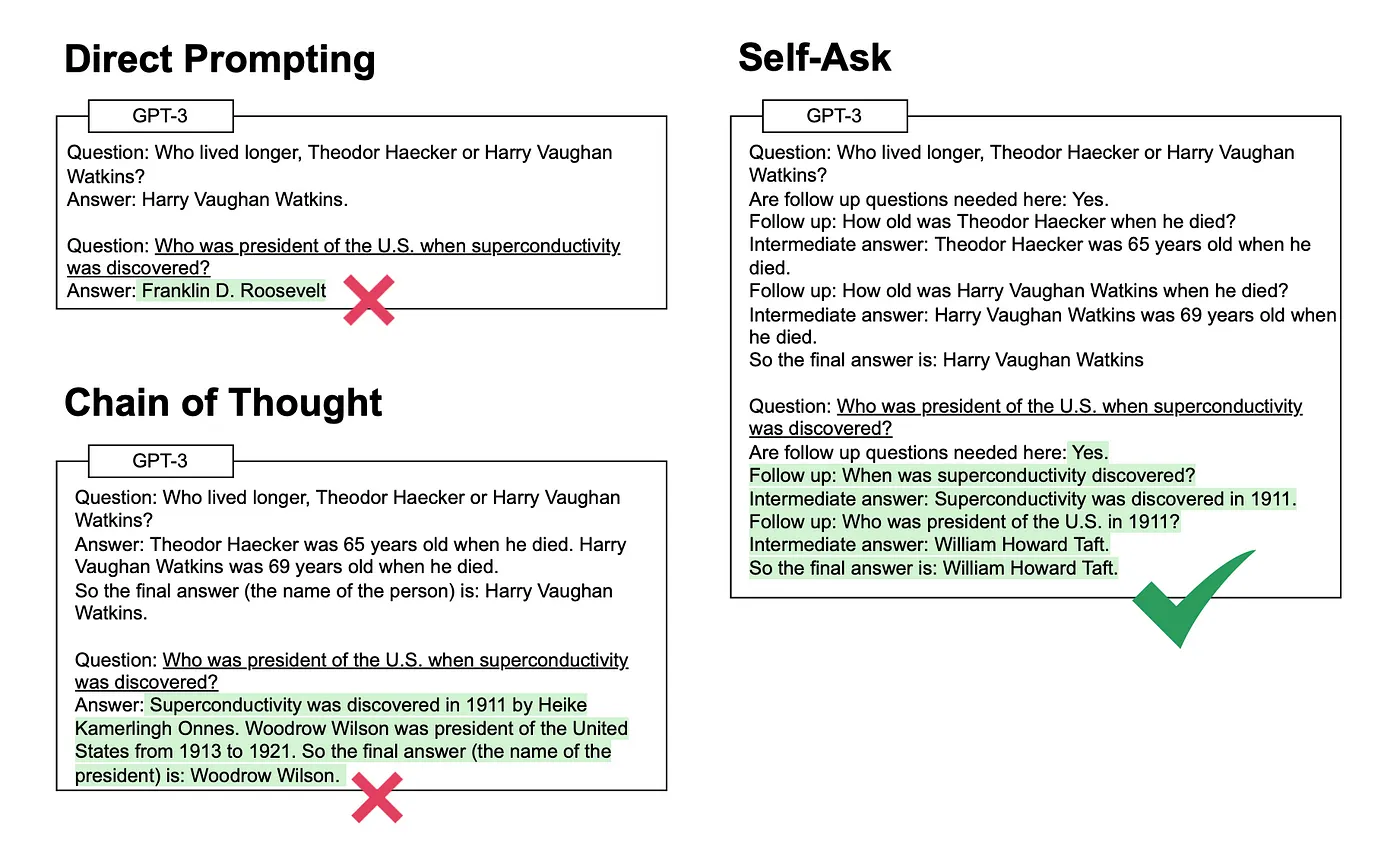

In [70]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun(name="Intermediate Answer") # This agent expects the tool to be named `Intermediate Answer`

In [71]:
tools = [search] # This agent expects exactly one tool

Prompt

In [72]:
# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/self-ask-with-search")

In [73]:
prompt

PromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'self-ask-with-search', 'lc_hub_commit_hash': '9ef33d1fc82608bdfaa88b3757306ec4f22511b736cb267b1737616641dac0cc'}, template='Question: Who lived longer, Muhammad Ali or Alan Turing?\nAre follow up questions needed here: Yes.\nFollow up: How old was Muhammad Ali when he died?\nIntermediate answer: Muhammad Ali was 74 years old when he died.\nFollow up: How old was Alan Turing when he died?\nIntermediate answer: Alan Turing was 41 years old when he died.\nSo the final answer is: Muhammad Ali\n\nQuestion: When was the founder of craigslist born?\nAre follow up questions needed here: Yes.\nFollow up: Who was the founder of craigslist?\nIntermediate answer: Craigslist was founded by Craig Newmark.\nFollow up: When was Craig Newmark born?\nIntermediate answer: Craig Newmark was born on December 6, 1952.\nSo the final answer is: December 6, 

In [74]:
print(prompt.template)

Question: Who lived longer, Muhammad Ali or Alan Turing?
Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali

Question: When was the founder of craigslist born?
Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952

Question: Who was the maternal grandfather of George Washington?
Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washin

Self ask agent

In [75]:
from langchain.agents import create_self_ask_with_search_agent


In [78]:
# Construct the Self Ask With Search Agent
agent = create_self_ask_with_search_agent(llm, tools, prompt)

# Create an agent executor by passing in the agent and tools
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)

In [79]:
agent_executor.invoke({"input": "How many moon does Saturn Have?"})



> Entering new AgentExecutor chain...
Could not parse output: No
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE Invalid or incomplete responseFollow up: How many moons does Saturn actually have?

/usr/local/lib/python3.10/dist-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


Saturn has 146 moons in its orbit, more than any other planet. The moons range in size from larger than the planet Mercury – the giant moon Titan – to as small ... There are 146 moons with confirmed orbits, the most of any planet in the solar system. This number does not include the many thousands of moonlets embedded ... As of June 2023, Saturn has 146 moons. Saturn's largest moon Titan is bigger than both Mercury and Pluto. Titan has a very thick atmosphere which is mostly ... Jun 15, 2023 ... Saturn has 146 moons recognized by the International Astronomical Union. The number of moons increased substantially in May 2023 when 62 new ... As of June 8, 2023, Saturn has 146 moons. And that's not counting Saturn's beautiful rings! Saturn's moons have great names like Mimas, Enceladus, and Tethys.So the final answer is: Saturn has 146 moons.

> Finished chain.


{'input': 'How many moon does Saturn Have?', 'output': 'Saturn has 146 moons.'}